In [3]:
import sys
sys.path.append('../src/')

# Tutorial: Solving Branched Optimal Transport problems

Welcome to this tutorial! Here, we will delve into a heuristic based on Monte Carlo optimization, which is used to generate solutions for BOT (Branching-Optimal Transport) problems.

Before we proceed, let's quickly recap the heuristic, which consists of two main parts:

1. **Optimizing the geometry of the network:**
   This part employs a numerical method that optimizes the positions of branching points in the network, focusing on convex optimization techniques. By fine-tuning the network's geometry while keeping the topology fixed, this method aims to enhance the overall performance.

2. **Optimizing the tree topology:**
   The second part of the heuristic involves a greedy randomized algorithm. It iteratively modifies the network's topology by randomly adding or removing edges, and then evaluates the impact on the solution's quality. Factors such as edge length, degree of branching, and crossing angles are considered by the algorithm, which guides the search for better solutions.

To apply the heuristic, we combine these two parts sequentially. Initially, the numerical method optimizes the geometry of the network, given a fixed topology. By solving a convex optimization problem, it determines the best positions for branching points.

Once the geometry has been optimized, we employ the greedy randomized algorithm to further enhance the solution by optimizing the tree topology. Through iterative modifications to the network, such as adding or removing edges, this algorithm explores the effects on the overall quality of the solution. Utilizing heuristics that consider various factors, it guides the search for improved solutions.

By combining these two components, the heuristic offers a powerful approach to tackling large-scale BOT problems. The numerical method optimizes the geometry while maintaining a fixed topology, while the greedy randomized algorithm focuses on optimizing the topology itself. Together, they provide an efficient and effective solution for BOT problems.

## Tutorial: Randomly generated BOT problem

Throughout this tutorial, we will explore how to utilize these methods to generate high-quality solutions. Let's get started!

### Step 1: Setup and Imports
To begin, we need to import the required modules and set up the necessary configurations. In this snippet, the following modules are imported:

In [75]:
import numpy as np
import time
import networkx as nx
import matplotlib.pyplot as plt
#-------------------------------------------
import utils
import iterative_geometry_solver as igs
import greedy_topology_optimization as gto 

The `numpy` module provides numerical operations and array manipulation capabilities. The `time` module is used to measure the execution time. The `networkx` module is used to represent and manipulate the graph data structure. The `utils` module contains utility functions required for the code execution.

### Step 2: Define Problem Parameters
Next, the code defines the problem parameters. The snippet contains the following lines:

In [56]:
seed=138
np.random.seed(seed)
num_terminals = 20

- `np.random.seed(17)`: Sets the random seed to ensure reproducibility of results.
- `T`: Represents the temperature, which is set to zero in this case.
- `num_terminals`: Specifies the number of terminals in the problem.

### Step 3: Generate Random Problem
The code generates a random problem using the `generate_random_bot_problem` function. It sets the number of sources and sinks randomly and retrieves the problem dictionary containing coordinates, supply, and demand arrays.

In [57]:
num_sources = np.random.randint(1, num_terminals)
num_sinks = num_terminals - num_sources
bot_problem_dict = utils.generate_random_bot_problem(num_sources, num_sinks, normalised_to=1, dim=2,
                                                       max_length=1.)

The content of the dictionary `bot_problem_dict` is as follows:

- `'al'`: The value of $\alpha$.
- `'coords_sources'`: A 2D NumPy array representing the coordinates of the sources. Each row corresponds to the coordinates of a source point in a two-dimensional space.
- `'coords_sinks'`: A 2D NumPy array representing the coordinates of the sinks. Each row corresponds to the coordinates of a sink point in a two-dimensional space.
- `'supply_arr'`: A 1D NumPy array representing the supply values for each source. Each element in the array corresponds to the supply value of a source point.
- `'demand_arr'`: A 1D NumPy array representing the demand values for each sink. Each element in the array corresponds to the demand value of a sink point.

We can see that the parameter $\alpha$ in this example is:

In [58]:
bot_problem_dict['al']

0.7052301115139145

Let's now extract the information defining the problem into a set of variables.

In [59]:
al = bot_problem_dict["al"]
coords_sources = bot_problem_dict["coords_sources"]
coords_sinks = bot_problem_dict["coords_sinks"]
supply_arr = bot_problem_dict["supply_arr"]
demand_arr = bot_problem_dict["demand_arr"]

Notice that in this case, the number of sources and sinks is:

In [81]:
print(len(coords_sources))
print(len(coords_sinks))

10
10


### Step 4: Initialize Star Graph
To begin, we will establish an initial topology to work with. In this particular case, we will create a star graph as our starting point.

In [82]:
# init star graph:
topo = nx.Graph()
for node in range(len(supply_arr) + len(demand_arr)):
    topo.add_edge(-1, node)

Notice that this graph has the following properties:

In [87]:
# The number of nodes
num_nodes = topo.number_of_nodes()
print("Number of nodes:", num_nodes)

# The number of edges
num_edges = topo.number_of_edges()
print("Number of edges:", num_edges)

Number of nodes: 21
Number of edges: 20


And it looks like this:

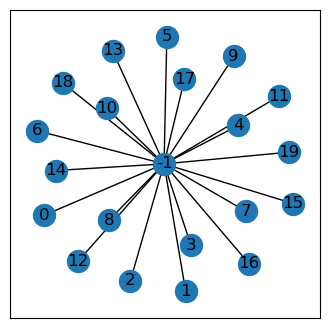

In [93]:
fig = plt.figure(figsize=(4, 4))
pos = nx.spring_layout(topo, seed = 1)
nx.draw_networkx(topo, pos = pos, node_size = 250, with_labels = True)

This graph can be considered as our initial approximation of the solution to the problem of connecting the given sources and sinks.

### Step 4: Geometry optimization


The next step is to perform the Monte Carlo optimization to update the topology. It uses the `iterative_geometry_solver` function to iteratively improve the solution. The function takes the initial topology, supply and demand arrays, coordinates of sources and sinks, and the alpha (al) value as parameters. The `relative_improvement_threshold`, `min_iterations`, and `max_iterations` control the stopping criteria and iteration limits.

More concretely, ```iterative_geometry_solver(topo, supply_arr, demand_arr, coords_sources, coords_sinks, al, relative_improvement_threshold=1e-5, min_iterations=30, max_iterations=300, use_python_implementation=False, plot=False, title="", fov=None, save=False, save_name="img")``` is the main function that solves the geometry optimization problem iteratively. It takes the topology, supply and demand arrays, coordinates of sources and sinks, and an alpha parameter as inputs. It also has several optional parameters for iteration, visualization, and saving the output. The function first checks the alpha parameter and the validity of the input data. If the topology is a full tree and certain visualization options are not enabled, it uses a fast C++ implementation for optimization. Otherwise, it continues with the Python implementation. The function preprocesses the topology, sets up necessary arrays, and initializes variables. It then performs iterative optimization of the branching point positions by solving a linear system of equations using numpy. The iteration stops when the relative improvement in cost falls below a threshold or the maximum number of iterations is reached. If visualization is enabled, the final solution is visualized. The function returns the cost of the minimal branching point configuration and the positions of the branching points.



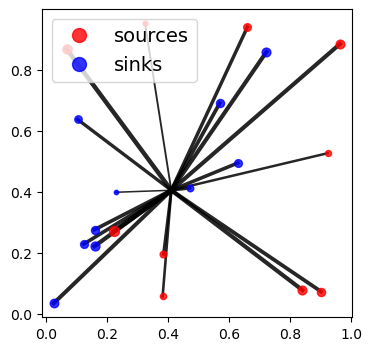

In [65]:

cost, coords_iter = igs.iterative_geometry_solver(topo, 
                                                  supply_arr, 
                                                  demand_arr, 
                                                  coords_sources, 
                                                  coords_sinks, 
                                                  al,
                                         relative_improvement_threshold=1e-6, min_iterations=-1,
                                         max_iterations=1000,
                                         plot=True, title="", fov=None, save=False, save_name="img",
                                                 figsize =(4,4))

### Step 5: Topology optimization

In the second step of the algorithm, we aim to refine the network structure to achieve an improved solution. We initialize some variables such as ```T```, ```keep_going```, ```iteration```, and ```sample_edge_list```. The while loop iterates until the termination condition is met or a maximum number of iterations (60,000 in this case) is reached. Within each iteration, the ```gto.monte_carlo_step()``` function is called to refine the topology by adjusting the network structure. The convergence is checked by verifying if the ```sample_edge_list``` is empty, indicating that the algorithm has stuck with one topology for the entire run. Finally, the iteration count and the elapsed time are printed to provide insights into the performance of the optimization process.

In [66]:
T = 0
keep_going = True
iteration = 0
sample_edge_list = list(topo.edges())

time0 = time.time()
while keep_going and iteration < 60000:
    iteration += 1
    topo, sample_edge_list, cost, coords_iter, accepted = gto.monte_carlo_step(topo, sample_edge_list, cost,
                                                                           coords_iter, bot_problem_dict,
                                                                           temperature=T)
    # check if converged:
    if len(sample_edge_list) == 0:
        # this means that we have stuck with one topology for an entire run through.
        keep_going = False

print(f"final result, after {iteration} iterations and {np.round(time.time() - time0, 2)} seconds.")

final result, after 176 iterations and 4.93 seconds.


### Step 6: Visualization of the solution

In this step, we visualize the solution obtained from the previous steps of the algorithm. The code snippet below demonstrates the visualization process:

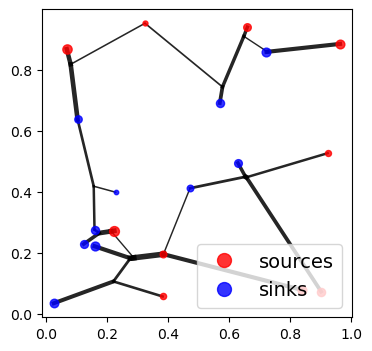

In [73]:
utils.visualise_BOT_solution(topo, 
                       coords_iter, 
                       supply_arr, 
                       demand_arr, 
                       title="", fov=None, save=False, save_name="img",
                       figsize = (4,4))

As we can observe, the branching points remain unchanged in this step. The only aspect that undergoes modification is the position of the edges. This would be the solution obtained by the algorithm for the given positions of sources and sinks, the given supply and demands, and hyperparameter $\alpha$. 

Congratulations!  We have successfully constructed our solution to a first BOT problem.